In [118]:
# !pip -q install plotly

In [119]:
import torch
import torch.nn as nn

import numpy as np
from scipy.special import sph_harm, gammaln, eval_genlaguerre

import matplotlib.pyplot as plt
import plotly.graph_objects as go # graficos interactivos que funcionan en un notebook
from plotly.subplots import make_subplots

import gc
import time

In [120]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [121]:
R_MAX  = 1.0      # simula infinito donde valores mayores a este se concideran 0
EPS_R  = 1e-3      # contra r=0 para evitar singularidad
EPS_TH = 1e-3      # contra sin(theta)=0 
N_INT  = 4000      # puntos interiores para residual PDE
N_R0   = 200       # puntos cerca del origen
N_POLO = 200       # puntos cerca de los polos
N_BC   = 400       # puntos en r = R_MAX (borde externo)










lambda_r0   = 1.0
lambda_polo = 1.0
lambda_bc   = 1.0
lambda_norm = 0.5

# Potencial V(r) = -1/r
def V_coulomb(r):
    return -1.0 / r.clamp_min(1e-8)

Con el aumento de las capas el orden de las perdidas diminuyo notablemente mas esto tiene un coste cada vez mas notorio en el tiempo de entrenamiento.
Visualmente el modelo genera algo asi como nucleos aleatoris desparramados en el espacio.\

En este momento llegado a un numero de 30 capas y 64 neuronas con 2_000 epocs el codigo demora unos 100 minutos en correrse.
Visualmente al pasar de 32 a 64 neuronas se localizo un nucleo desparramado en uno de los polos.\

80 neuronas, 30 layers, 1_000 epocs ya son mas de 160 minutos
Genero una visualisacion de medio cascaron con puntos desparramados en el.\

80 neuronas, 10 layers, 1_000 epocs 4 minutos, loss volvi a los ordenes e2 a e14
Genero una visualisacion de durazno hueco con nucleo desparramado en un polo.\

40 neuronas, 15 layers, 1_000 epocs 6 minutos, loss e0 a e10
Genero una visualisacion de durazno hueco con nucleo desparramado en un polo.
Sin normalisacion\

las exploraciones de inicializacion de distintos tipos no a sido muy satisfactoria, en general la perdida aumenta mucho

ortogonal con 5000 epochs dio tipo esfera deformada pero el nucleo bastante grande


In [122]:
# Por ahora esta configuracion entrega los resultado mas proximos al resultado conocido e=2_000, l=4, n=35, para tanh
# Por ahora esta configuracion entrega los resultado mas proximos al resultado conocido e=10_000, l=4, n=35, para sin

# l=35 n=32 e=2k  -1 a 0 peaks 5

epocs = 2_000
layers = 35 # -1 2 --- 35
n_neuronas = 32
lr = 1e-3

In [123]:
class Activation(nn.Module):
    def forward(self, x):
        return torch.sin(x)

class MLP(nn.Module):

    def __init__(self, in_dim=5, out_dim=1, width=n_neuronas, depth=layers):
        super().__init__()
        self.Lin_E    = torch.nn.Linear(1,1) 
        layers = [nn.Linear(in_dim, width), Activation()]
        for _ in range(depth-1):
            layers += [nn.Linear(width, width), Activation()]
        layers += [nn.Linear(width, out_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, x, a=0): 
        ones = torch.ones(x.size(0), 1, device=x.device, dtype=x.dtype)*0.5
        E_tr = self.Lin_E(ones)                          
        E_tr = -torch.abs(E_tr)                          
        return self.net(torch.cat((x, E_tr), dim=1)), E_tr

In [124]:
torch.manual_seed(123)

def init_tanh_xavier(module):
    if isinstance(module, nn.Linear):
        g = nn.init.calculate_gain('tanh')
        nn.init.xavier_uniform_(module.weight, gain=g)  # U[-a,a] con a dependiente de fan_in/out
        nn.init.zeros_(module.bias)

def init_normal_0p03(module):
    if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, mean=0.0, std=0.03)  # N(0, 0.03^2)
        nn.init.zeros_(module.bias)

def init_uniform_range(module, a=0.1):
    if isinstance(module, nn.Linear):
        nn.init.uniform_(module.weight, -a, a)             # U[-a, a]
        nn.init.constant_(module.bias, 0.0)

def init_orthogonal(module):
    if isinstance(module, nn.Linear):
        nn.init.orthogonal_(module.weight, gain=1.0)       # pesos ortogonales
        nn.init.zeros_(module.bias)

def init_relu_kaiming(module):
    if isinstance(module, nn.Linear):
        nn.init.kaiming_normal_(module.weight, nonlinearity='relu')  # o 'leaky_relu', 'silu'
        nn.init.zeros_(module.bias)

In [125]:
# modelo para la funcion de onda y parametro para la energia a ser entrenados
# la energia es un parametro mas entrenable y este puede ser recuperado para comparar con la energia conocida

psi_net = MLP().to(device)

psi_net.apply(init_relu_kaiming)

MLP(
  (Lin_E): Linear(in_features=1, out_features=1, bias=True)
  (net): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): Activation()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Activation()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Activation()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Activation()
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): Activation()
    (10): Linear(in_features=32, out_features=32, bias=True)
    (11): Activation()
    (12): Linear(in_features=32, out_features=32, bias=True)
    (13): Activation()
    (14): Linear(in_features=32, out_features=32, bias=True)
    (15): Activation()
    (16): Linear(in_features=32, out_features=32, bias=True)
    (17): Activation()
    (18): Linear(in_features=32, out_features=32, bias=True)
    (19): Activation()
    (20): Linear(in_features=32, out_features=32, bias=True)
    (21): Activation()
 

In [126]:
def grad_wrt(y, x):
    return torch.autograd.grad(y, x, torch.ones_like(y), retain_graph=True, create_graph=True)[0]

def laplacian_spherical(psi, r, th, ph):

    psi_r   = grad_wrt(psi, r)
    psi_rr  = grad_wrt(psi_r, r)
    psi_th  = grad_wrt(psi, th)
    psi_thth= grad_wrt(psi_th, th)

    psi_ph  = grad_wrt(psi, ph)
    psi_phph= grad_wrt(psi_ph, ph)

    r2     = r**2
    sin_th = th.sin().clamp_min(1e-6) # asegura que sin no llegue a 0

    term_r  = (1.0/r2) * (2.0*r*psi_r + r2*psi_rr)
    term_th = (1.0/(r2*sin_th)) * (th.cos()*psi_th + sin_th*psi_thth)
    term_ph = (1.0/(r2*(sin_th**2))) * psi_phph
    return term_r + term_th + term_ph

def psi_forward(r, th, ph):
    
    x = torch.cat([r, th, ph.cos(), ph.sin()], dim=1)
    return psi_net(x)


In [127]:
# muestras 
def sample_interior(n):
    r  = torch.rand(n,1, device=device)*(R_MAX - EPS_R) + EPS_R
    th = torch.rand(n,1, device=device)*(torch.pi - 2*EPS_TH) + EPS_TH
    ph = torch.rand(n,1, device=device)*(2*torch.pi)
    r.requires_grad_(True); th.requires_grad_(True); ph.requires_grad_(True)
    return r, th, ph

def sample_origin(n):
    
    r  = torch.full((n,1), EPS_R, device=device, requires_grad=True)
    th = torch.rand(n,1, device=device)*(torch.pi - 2*EPS_TH) + EPS_TH
    ph = torch.rand(n,1, device=device)*(2*torch.pi)
    th.requires_grad_(True); ph.requires_grad_(True)
    return r, th, ph

def sample_poles(n):
    
    r  = torch.rand(n,1, device=device)*(R_MAX - 2*EPS_R) + 2*EPS_R
    th_top = torch.full((n//2,1), EPS_TH, device=device, requires_grad=True)
    th_bot = torch.full((n - n//2,1), torch.pi - EPS_TH, device=device, requires_grad=True)
    th = torch.cat([th_top, th_bot], dim=0)
    ph = torch.rand(n,1, device=device)*(2*torch.pi)
    r.requires_grad_(True); ph.requires_grad_(True)
    return r, th, ph

def sample_boundary(n):
    
    r  = torch.full((n,1), R_MAX, device=device, requires_grad=True)
    th = torch.rand(n,1, device=device)*(torch.pi - 2*EPS_TH) + EPS_TH
    ph = torch.rand(n,1, device=device)*(2*torch.pi)
    th.requires_grad_(True); ph.requires_grad_(True)
    return r, th, ph


In [128]:
############################ NORMALIZACION!!
def quadrature_points(nr, nt, np_):
    r  = torch.linspace(EPS_R, R_MAX, nr, device=device).view(-1,1)
    th = torch.linspace(EPS_TH, torch.pi - EPS_TH, nt, device=device).view(-1,1)
    ph = torch.linspace(0.0, 2*torch.pi, np_, device=device).view(-1,1)

    def trap_w(n, a, b):
        w = torch.ones(n,1, device=device)
        w[0] = 0.5; w[-1] = 0.5
        return w * ((b-a)/(n-1))

    wr  = trap_w(nr, float(EPS_R), float(R_MAX))
    wth = trap_w(nt, float(EPS_TH), float(torch.pi - EPS_TH))
    wph = trap_w(np_, 0.0, 2*torch.pi)

    # producto tensorial
    r_g  = r.repeat_interleave(nt*np_, dim=0)
    th_g = th.repeat_interleave(np_, dim=0).repeat(nr,1)
    ph_g = ph.repeat(nt,1).repeat(nr,1)

    wr_g  = wr.repeat_interleave(nt*np_, dim=0)
    wth_g = wth.repeat_interleave(np_, dim=0).repeat(nr,1)
    wph_g = wph.repeat(nt,1).repeat(nr,1)

    r_g.requires_grad_(True); th_g.requires_grad_(True); ph_g.requires_grad_(True)
    return r_g, th_g, ph_g, wr_g, wth_g, wph_g

In [129]:
TARGET_LOSS = 1e-2     # umbral deseado para L
CHECK_EVERY = 10       # comprueba en cada paso (puedes subirlo para menos overhead)

# Opcional: early stop por paciencia (desactiva poníendolo en None)
PATIENCE_STEPS = None  # por ejemplo 200 si quieres paciencia
MIN_DELTA = 0.0        # mejora mínima para resetear paciencia

best_loss = float('inf')
no_improve = 0


In [130]:
# train
optim = torch.optim.Adam(psi_net.parameters(), lr)

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, patience=100)

scheduler     =  torch.optim.lr_scheduler.CyclicLR(optim, base_lr=1e-4, max_lr=1e-3, mode='triangular', cycle_momentum=False)

loss_valores = []
loss_pde = []
loss_origin = []
loss_poles = []
loss_bc = []
loss_norm = []

tiempo_0 = time.time() 

for step in range(epocs):
    optim.zero_grad()

    # residuo
    r_i, th_i, ph_i = sample_interior(N_INT)
    psi_i , E = psi_forward(r_i, th_i, ph_i)
    lap_i = laplacian_spherical(psi_i, r_i, th_i, ph_i)
    resid = -0.5*lap_i + V_coulomb(r_i)*psi_i - E*psi_i
    L_pde = (resid**2).mean()
    
    # origen
    r0, th0, ph0 = sample_origin(N_R0)
    psi_0    = psi_forward(r0, th0, ph0)[0]
    psi_th_0 = grad_wrt(psi_0, th0)
    psi_ph_0 = grad_wrt(psi_0, ph0)
    L_origin = (psi_0**2 + psi_th_0**2 + psi_ph_0**2).mean()

    # polos
    rp, thp, php = sample_poles(N_POLO)
    psi_p    = psi_forward(rp, thp, php)[0]
    psi_ph_p = grad_wrt(psi_p, php)
    L_poles  = (psi_ph_p**2).mean()

    # bordes
    rb, thb, phb = sample_boundary(N_BC)
    psi_b = psi_forward(rb, thb, phb)[0]
    L_bc  = (psi_b**2).mean()
    
   
    # Normalización por Monte Carlo en el interior
    sin_th = th_i.sin().clamp_min(1e-6)                      # evita 0 exacto
    vol = (R_MAX - EPS_R) * np.pi * (2*np.pi)                # = 2π^2 (R_MAX - EPS_R)
    norm_est = vol * ((psi_i**2) * (r_i**2) * sin_th).mean() # ≈ ∫ |ψ|^2 dV
    L_norm = (norm_est - 1.0)**2


    # funcion de perdida total
    L = L_pde + lambda_r0*L_origin + lambda_polo*L_poles + lambda_bc*L_bc  +  lambda_norm*L_norm 

    loss_valores.append(L.item())
    loss_pde.append(L_pde.item()) 
    loss_origin.append(L_origin.item()) 
    loss_poles.append(L_poles.item()) 
    loss_bc.append(L_bc.item()) 
    #loss_norm.append(L_norm.item()) 

    L.backward()
    optim.step()
    
        # --- Early stop por umbral ---
    if step % CHECK_EVERY == 0:
        curr_loss = L.item()
        if curr_loss <= TARGET_LOSS:
            print(f"[EARLY STOP] Se alcanzó el umbral TARGET_LOSS={TARGET_LOSS:.3e} en step {step} (L={curr_loss:.3e}).")
            break

    scheduler.step(L.item())


    if step % 200 == 0:
        print(f"step {step:4d} | L={L.item():.3e} | E={E[0].item():.6f} | {round(step*100/epocs,1)}% {int((abs(tiempo_0-time.time())*abs(epocs-step)/(step+0.00000001))/60)} minutos restantes")


step    0 | L=9.698e+15 | E=-0.946920 | 0.0% 1620549360 minutos restantes
step  200 | L=2.051e+16 | E=-0.947070 | 10.0% 5 minutos restantes
step  400 | L=1.056e+18 | E=-0.947070 | 20.0% 4 minutos restantes
step  600 | L=4.353e+17 | E=-0.947070 | 30.0% 4 minutos restantes
step  800 | L=2.762e+15 | E=-0.947070 | 40.0% 3 minutos restantes
step 1000 | L=7.963e+16 | E=-0.947070 | 50.0% 4 minutos restantes
step 1200 | L=6.073e+18 | E=-0.947070 | 60.0% 4 minutos restantes
step 1400 | L=2.542e+17 | E=-0.947070 | 70.0% 3 minutos restantes
step 1600 | L=5.085e+17 | E=-0.947070 | 80.0% 2 minutos restantes
step 1800 | L=1.230e+17 | E=-0.947070 | 90.0% 1 minutos restantes


"plt.subplot(2,3,6)\nplt.plot(loss_norm)\nplt.yscale('log') \nplt.title('Loss normalización')  "

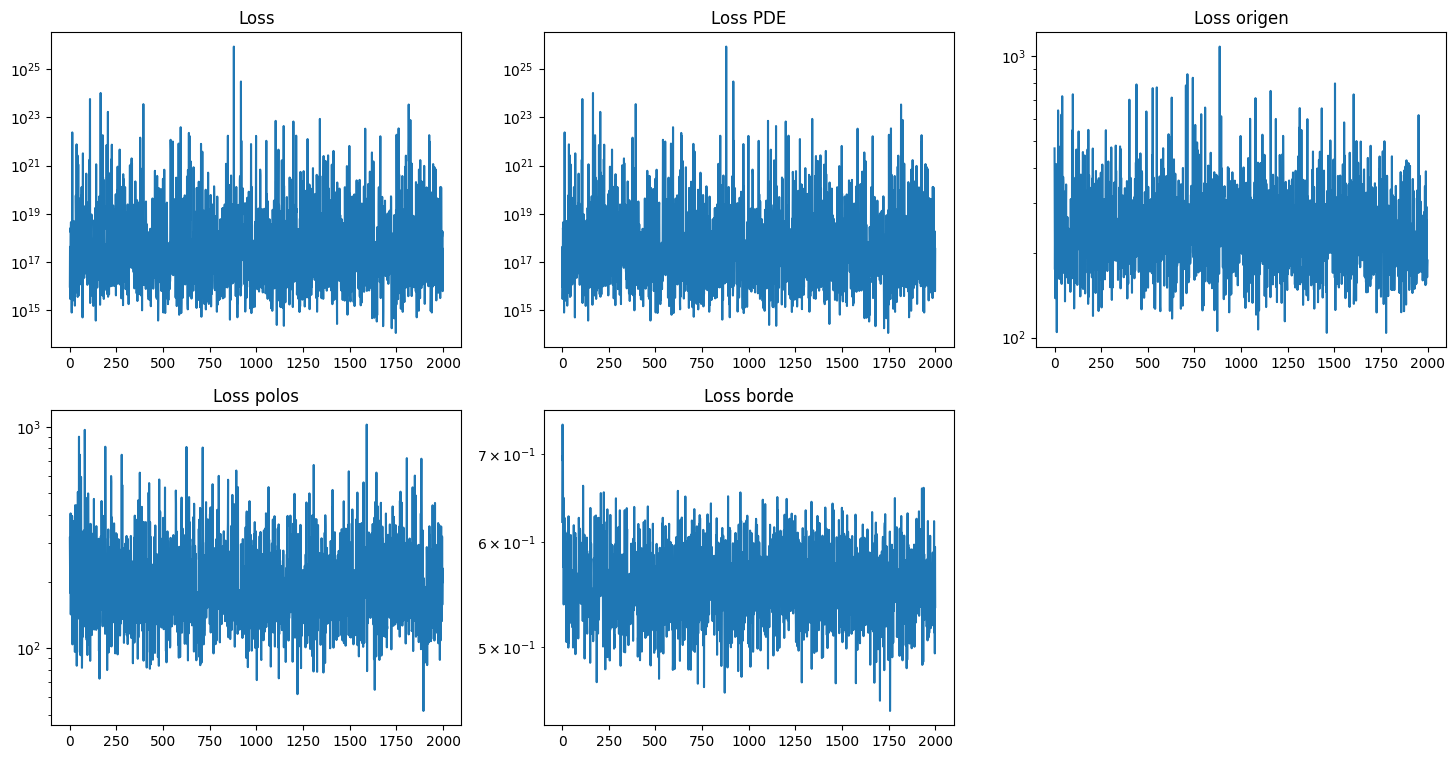

In [131]:
plt.figure(figsize=(18,9))

plt.subplot(2,3,1)
plt.plot(loss_valores)
plt.yscale('log') 
plt.title('Loss')

plt.subplot(2,3,2)
plt.plot(loss_pde)
plt.yscale('log') 
plt.title('Loss PDE')

plt.subplot(2,3,3)
plt.plot(loss_origin)
plt.yscale('log') 
plt.title('Loss origen')

plt.subplot(2,3,4)
plt.plot(loss_poles)
plt.yscale('log') 
plt.title('Loss polos')

plt.subplot(2,3,5)
plt.plot(loss_bc)
plt.yscale('log') 
plt.title('Loss borde')

'''plt.subplot(2,3,6)
plt.plot(loss_norm)
plt.yscale('log') 
plt.title('Loss normalización')  '''



Text(0.5, 1.0, 'Loss')

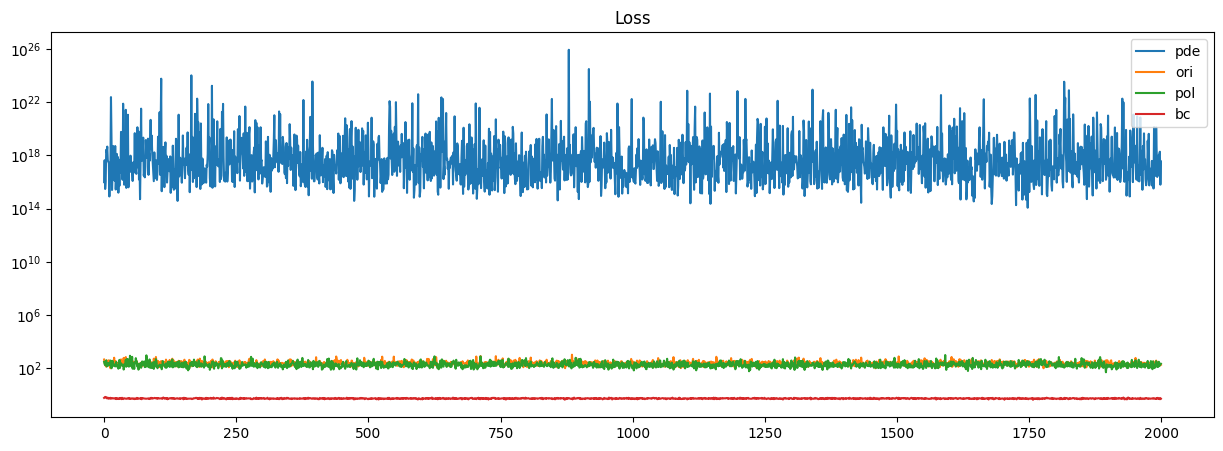

In [132]:
plt.figure(figsize=(15,5))

plt.plot(loss_pde,label='pde')
plt.plot(loss_origin,label='ori')
plt.plot(loss_poles,label='pol')
plt.plot(loss_bc,label='bc')
#plt.plot(loss_norm,label='nor')
plt.legend()
plt.yscale('log') 
plt.title('Loss')

In [133]:
#graficos

def cartesian_grid(N=48, L=12.0, device='cpu'):
    xs = torch.linspace(-L, L, N, device=device)
    ys = torch.linspace(-L, L, N, device=device)
    zs = torch.linspace(-L, L, N, device=device)
    X, Y, Z = torch.meshgrid(xs, ys, zs, indexing='ij')
    return X, Y, Z

def cartesian_to_spherical(x, y, z, eps=1e-12):
    r  = torch.sqrt(x*x + y*y + z*z + eps)
    th = torch.acos(torch.clamp(z / r, -1.0, 1.0))
    ph = torch.atan2(y, x)
    return r, th, ph

def evaluate_model_on_grid(psi_net, X, Y, Z, batch=200_000, is_complex=False, r_clip=None):
    device = next(psi_net.parameters()).device
    
    N = X.shape[0]
    x = X.reshape(-1,1).to(device)
    y = Y.reshape(-1,1).to(device)
    z = Z.reshape(-1,1).to(device)

    r, th, ph = cartesian_to_spherical(x, y, z)
    inp = torch.cat([r, th, torch.cos(ph), torch.sin(ph)], dim=1)

    out_list = []
    for i in range(0, inp.shape[0], batch):
        out = psi_net(inp[i:i+batch])[0]
        out_list.append(out)
    out = torch.cat(out_list, dim=0)

    if is_complex:
        psi_re = out[:,0:1]
        psi_im = out[:,1:2]
        rho = psi_re.pow(2) + psi_im.pow(2)
    else:
        rho = out[:,0:1].pow(2)

    if r_clip is not None:
        mask = (r.squeeze(1) <= r_clip).float().unsqueeze(1)
        rho = rho * mask

    return rho.reshape(N,N,N).detach().cpu().numpy()

## solucion conocida

def hydrogen_radial_Rnl(n, l, r, a0=1.0):
    rho = 2.0*r/(n*a0)
    log_ratio = gammaln(n-l) - gammaln(n+l+1)
    pref = (2.0/(n*a0))**1.5 * np.sqrt(np.exp(log_ratio)/(2.0*n))
    L = eval_genlaguerre(n-l-1, 2*l+1, rho)
    return pref * np.exp(-rho/2.0) * (rho**l) * L

def evaluate_exact_on_grid(X, Y, Z, n=1, l=0, m=0, a0=1.0, r_clip=None):
    Xn, Yn, Zn = X.detach().cpu().numpy(), Y.detach().cpu().numpy(), Z.detach().cpu().numpy()
    r = np.sqrt(Xn**2 + Yn**2 + Zn**2)
    th = np.arccos(np.clip(Zn/(r+1e-12), -1.0, 1.0))
    ph = np.arctan2(Yn, Xn)
    Rnl = hydrogen_radial_Rnl(n,l,r,a0)
    Ylm = sph_harm(m,l,ph,th)
    psi = Rnl*Ylm
    rho = np.abs(psi)**2
    if r_clip is not None:
        rho = rho*(r<=r_clip)
    return rho



def subplot_isosurfaces(X, Y, Z, rho_model, rho_exact, rho_error,
                        percentile=0.92, layers=5, title="Comparación PINN vs Exacto"):

    def make_iso(X,Y,Z,vals,name):
        flat = vals.flatten()
        isomin = float(np.quantile(flat, percentile))
        isomax = float(flat.max())
        return go.Isosurface(
            x=X.flatten(), y=Y.flatten(), z=Z.flatten(),
            value=vals.flatten(),
            isomin=isomin, isomax=isomax,
            surface_count=layers,
            opacity=0.6,
            caps=dict(x_show=False,y_show=False,z_show=False),
            colorbar=dict(title=name),
            name=name,
            showscale=True
        )

    fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=("PINN", "Exacto", "Error"),
        specs=[[{'type':'scene'}, {'type':'scene'}, {'type':'scene'}]]
    )

    fig.add_trace(make_iso(X,Y,Z,rho_model," "), row=1,col=1)
    fig.add_trace(make_iso(X,Y,Z,rho_exact," "), row=1,col=2)
    fig.add_trace(make_iso(X,Y,Z,rho_error," "), row=1,col=3)

    fig.update_layout(title=title, width=1500, height=600)
    return fig


# Grid
N_GRID = 48
L_BOX  = 12.0
R_CLIP = 10.0
X,Y,Z = cartesian_grid(N=N_GRID,L=L_BOX,device=next(psi_net.parameters()).device)

# modelo y exacto
rho_model = evaluate_model_on_grid(psi_net, X,Y,Z, is_complex=False, r_clip=R_CLIP)
rho_exact = evaluate_exact_on_grid(X,Y,Z, n=1, l=0, m=0, r_clip=R_CLIP)


rho_error = np.abs(rho_model - rho_exact)

# plot
fig = subplot_isosurfaces(
    X.cpu().numpy(), Y.cpu().numpy(), Z.cpu().numpy(),
    rho_model, rho_exact, rho_error,
    percentile=0.92, layers=3,
    title="Hidrogeno: PINN vs Exacto"
)
fig.show()


C:\Users\danhm\AppData\Local\Temp\ipykernel_10284\2490365672.py:61: DeprecationWarning:

`scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.



In [134]:

def _to_numpy(a):
    if isinstance(a, np.ndarray):
        return a
    try:
        import torch
        if isinstance(a, torch.Tensor):
            return a.detach().cpu().numpy()
    except Exception:
        pass
    return np.asarray(a)

# --- prepara x,y,z,v: convierte, aplana, filtra por percentil y submuestrea ---
def _prep_xyzv(X, Y, Z, vals, percentile=0.90, max_points=60_000, rng=None):
    X = _to_numpy(X); Y = _to_numpy(Y); Z = _to_numpy(Z); vals = _to_numpy(vals)

    x = X.ravel(); y = Y.ravel(); z = Z.ravel(); v = vals.ravel()

    # quitar no finitos
    finite = np.isfinite(x) & np.isfinite(y) & np.isfinite(z) & np.isfinite(v)
    x, y, z, v = x[finite], y[finite], z[finite], v[finite]
    if v.size == 0:
        return np.array([np.nan]), np.array([np.nan]), np.array([np.nan]), np.array([0.0])

    # percentil seguro
    pct = float(np.clip(percentile, 0.0, 1.0))
    thr = np.nanquantile(v, pct)
    mask = v >= thr
    # fallback si quedó vacío
    if not np.any(mask):
        thr = np.nanquantile(v, 0.5)
        mask = v >= thr

    x, y, z, v = x[mask], y[mask], z[mask], v[mask]

    # submuestreo
    if x.size > max_points:
        if rng is None:
            rng = np.random.default_rng()
        idx = rng.choice(x.size, size=max_points, replace=False)
        x, y, z, v = x[idx], y[idx], z[idx], v[idx]

    if x.size == 0:
        return np.array([np.nan]), np.array([np.nan]), np.array([np.nan]), np.array([0.0])

    return x, y, z, v

def _make_scatter3d(X, Y, Z, vals, name,
                    percentile=0.90, max_points=60_000, point_size=2, opacity=0.6,
                    colorscale="Viridis"):
    x, y, z, v = _prep_xyzv(X, Y, Z, vals, percentile, max_points)
    return go.Scatter3d(
        x=x, y=y, z=z, mode="markers",
        marker=dict(size=point_size, opacity=opacity, color=v,
                    colorscale=colorscale, showscale=True, colorbar=dict(title=name)),
        name=name
    )

def subplot_scatter3d(X, Y, Z, rho_model, rho_exact, rho_error,
                      percentile=0.90, max_points=60_000, point_size=2, opacity=0.6,
                      title="Comparación PINN vs Exacto (Scatter 3D)", colorscale="Viridis"):
    fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=("PINN", "Exacto", "Error"),
        specs=[[{'type':'scene'}, {'type':'scene'}, {'type':'scene'}]]
    )

    fig.add_trace(_make_scatter3d(X,Y,Z,rho_model,"PINN",
                                  percentile,max_points,point_size,opacity,colorscale), row=1, col=1)
    fig.add_trace(_make_scatter3d(X,Y,Z,rho_exact,"Exacto",
                                  percentile,max_points,point_size,opacity,colorscale), row=1, col=2)
    fig.add_trace(_make_scatter3d(X,Y,Z,rho_error,"Error",
                                  percentile,max_points,point_size,opacity,colorscale), row=1, col=3)

    fig.update_layout(
        title=title, width=1500, height=600,
        scene=dict(aspectmode='cube'),
        scene2=dict(aspectmode='cube'),
        scene3=dict(aspectmode='cube')
    )
    return fig

fig = subplot_scatter3d(X, Y, Z, rho_model, rho_exact, rho_error, percentile=0.9, max_points=10_000)
fig.show()
